#### Шаг 1. Импорт бибилотек. Загрузка данных

In [50]:
#импортируем все необходимые для обработки и последующего анализа библиотеки
#импорт библиотеки pandas
import pandas as pd
#импорт библиотеки matplotlib
import matplotlib.pyplot as plt
#импорт библиотеки numpy
import numpy as np
#импорт библиотеки stats
from scipy import stats as st

In [2]:
#читаем необходимые файлы и сохраняем в трех датафрэймах
try:
    user = pd.read_csv('/datasets/users_go.csv')
except: 
    user = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
try:
    ride = pd.read_csv('/datasets/rides_go.csv')
except: 
    ride = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [4]:
try:
    subscribe = pd.read_csv('/datasets/subscriptions_go.csv')
except: 
    subscribe = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [5]:
#выведем первые строки каждого набора данных для первоначальной оценки
#датафрэйм с информацией о пользователях
user.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [6]:
#общие характеристики данных в user
user.info()
#первоначальные размерные характеристики user
print('Исходное состояние DataFrame', user.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
Исходное состояние DataFrame (1565, 5)


In [7]:
#датафрэйм с информацией о поездках пользователей
ride.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
#общие характеристики данных в ride
ride.info()
#первоначальные размерные характеристики ride
print('Исходное состояние DataFrame', ride.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
Исходное состояние DataFrame (18068, 4)


In [9]:
#датафрэйм с информацией о типе подписки 
subscribe

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
#общие характеристики данных в subscribe
subscribe.info()
#первоначальные размерные характеристики subscribe
print('Исходное состояние DataFrame', subscribe.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes
Исходное состояние DataFrame (2, 4)


**Вывод:**
* на первый взгляд данные вполне корректны
* определенно стоит изменить тип данных в столбце 'date', датафрэйм ride

#### Шаг 2. Предобработка данных

##### Замена типа данных

In [11]:
#по итогам этапа загрузки данных и поверхностной оценки их состояния
#прибегнем к замене типа данных в столбце 'date' датафрэйма ride на более предпочтительный
ride['date'] = pd.to_datetime(ride['date'], format='%Y.%m.%d')
#проверим как сработал примененный метод
ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создание нового столдца

In [12]:
#предварительно, убедимся в том, что исследуемый временной отрезок
#не превышает одного года, иначе данные по повторяющимся месяцам попадут в единый массив
#дата начала периода
print('Дата начала исследуемого периода', ride['date'].min())
#дата окончания исследуемого периода
print('Дата окончания исследуемого периода', ride['date'].max())

Дата начала исследуемого периода 2021-01-01 00:00:00
Дата окончания исследуемого периода 2021-12-30 00:00:00


In [13]:
#создадим отдельный столбец 'date_month', отражающий месяц, в датафрэйме ride
ride['date_month'] = pd.DatetimeIndex(ride['date']).month
#далее выведем первые строки 
ride.head()

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Проверка на наличие пропущенных значений и дубликатов

In [14]:
#на данным этапе работы актуальным будет проверить наши наборы данных
#на наличие пропущеных значений, начнем с user
user.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
#проверка ride на наличие пропусков
ride.isna().sum()

user_id       0
distance      0
duration      0
date          0
date_month    0
dtype: int64

In [16]:
#с пропусками все хорошо, а вот как обстоит ситуация с дубликатами
#на этот факт будет кстати проверить в датафрэйм user методом duplicated()
user.duplicated().sum()

31

In [17]:
#удалим выявленные дубликаты методом drop_duplicates()
user.drop_duplicates(inplace=True)

In [18]:
#оценим результат
user.duplicated().sum()

0

In [19]:
#проверим датафрэйм ride на дубликаты
ride.duplicated().sum()

0

In [20]:
#и датафрэйм subscribe
subscribe.duplicated().sum()

0

**Вывод**
* во всех трех наборах данных пропуски отсутствуют, что не может не радовать
* проверка на дубликаты выявила их наличие в датафрэйме user, после чего мы от них избавились

#### Шаг 3. Исследовательский анализ данных

In [21]:
#приступаем к описанию и визуализации интересующих нас данных
#первоначально сформируем понимание распределения пользователей по городам
city_count = user['city'].value_counts()
city_count

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

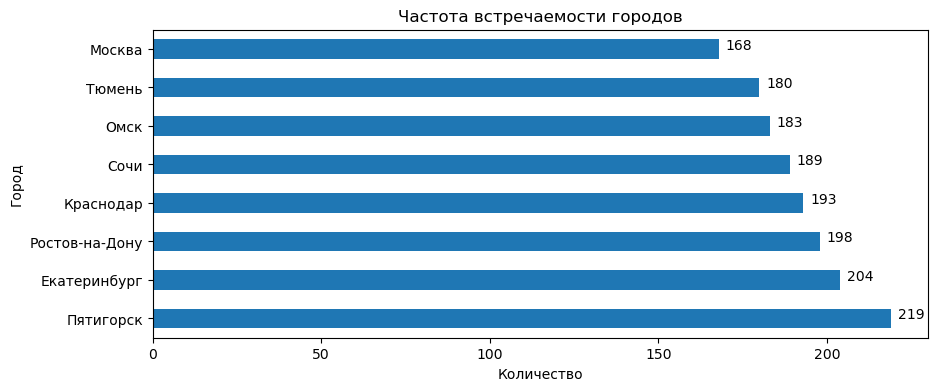

In [22]:
#начнем с частоты встречаемости городов, построим для этого столбца диаграмму
user['city'].value_counts().plot(kind='barh', y=city_count, figsize=(10, 4), title='Частота встречаемости городов')
plt.xlabel('Количество')
plt.ylabel('Город')
plt.text(221, 0, '219')
plt.text(206, 1, '204')
plt.text(200, 2, '198')
plt.text(195, 3, '193')
plt.text(191, 4, '189')
plt.text(185, 5, '183')
plt.text(182, 6, '180')
plt.text(170, 7, '168')
plt.show()

По полученной диаграмме можно сделать вывод, что наименьшее количество пользователей в исследуемом датафрэйме проживает в Москве (168). А в свою очередь наибольшее количество в Пятигорске (219).

In [23]:
#перед визуализацией распределения пользователей по признаку подписки
#выведем их численно
sub_type = user['subscription_type'].value_counts()
sub_type

free     835
ultra    699
Name: subscription_type, dtype: int64

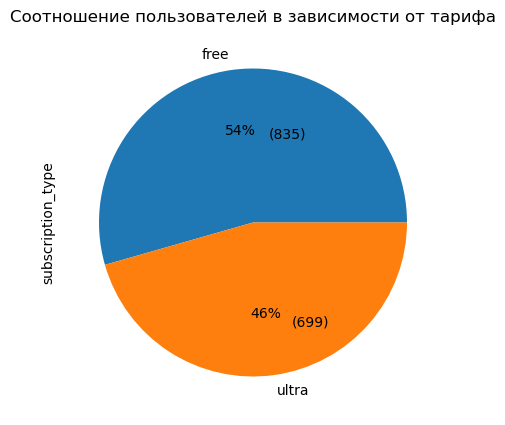

In [24]:
#посредством круговой диаграммы определим соотношение пользователей с подпиской и без
user['subscription_type'].value_counts().plot(
    kind='pie', y=sub_type, autopct = '%1.0f%%', 
    figsize=(5, 5), title='Соотношение пользователей в зависимости от тарифа')
plt.text(0.25, -0.67, '(699)')
plt.text(0.1, 0.55, '(835)')
plt.show()

Пользователи, не имеющие регулярную подписку преобладают, но разница не так велика, их 54% (835) от общего количества пользователей. Пользователи обладающие подпиской представлены в объеме 46% (699).

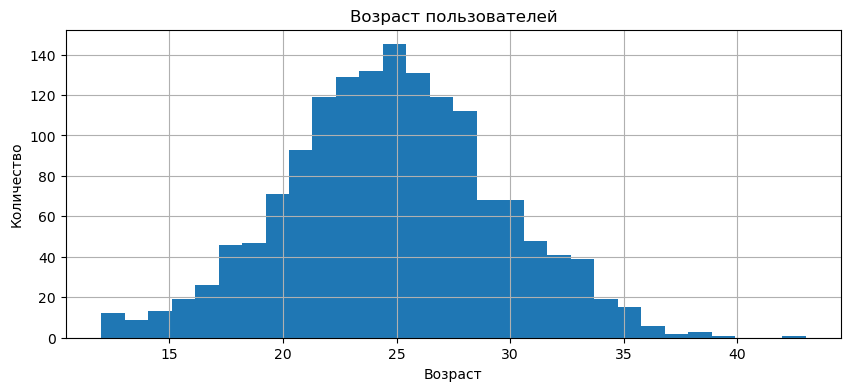

In [25]:
#перейдем к оценке распределения возраста пользователей через гистограмму
user['age'].hist(bins=30, grid=True, figsize=(10, 4))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

In [26]:
#применив метод describe() можно понять
#в каком возрастном диапазоне находится основная часть пользователей
user['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

В результате на гистаграмме мы наблюдаем классическое нормальное распределение, со средним значением равным 25. Условно, глядя на персентили 25 и 75, можно выделить возраст основной части пользователей и это 22 - 28 лет.

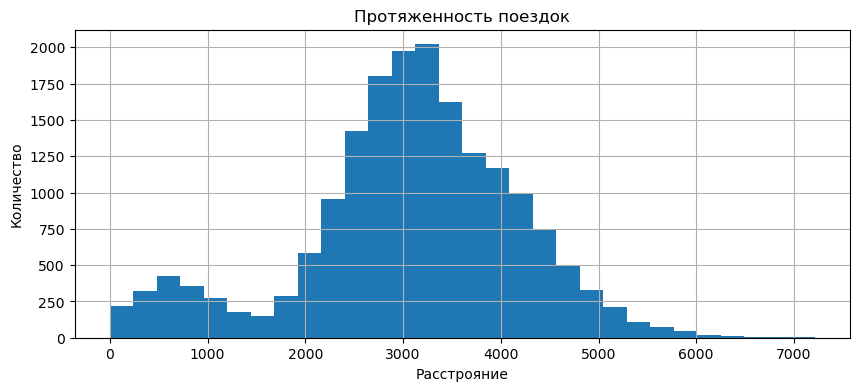

In [27]:
#гистагромма, отображающая распределение данных в столбце 'distance', датафрэйм ride 
ride['distance'].hist(bins=30, grid=True, figsize=(10,4))
plt.title('Протяженность поездок')
plt.xlabel('Расстрояние')
plt.ylabel('Количество')
plt.show()

In [28]:
#применив метод describe() можно понять
#в каком диапазоне находится наиболее частая протяженность поездок
ride['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Данные по расстоянию за одну поездку скорее напоминают нормальное распределение со средним значением - 3000 метров, что вполне правдоподобно. Единственное что может смущать, это участок от 0 до 1000 метров, где наблюдается рост, а затем снижение количества поездок в этом диапазоне. Дабы объяснить полученную особенность, можно предположить, что на это влияет цель поездки. Вероятно, поездки в 2000 метров и более имеют своей целью прогулку (в сквере, парке и т.д.). А в свою очередь короткие, до 1000 метров, могут быть в качестве транзитных, между двумя остановками общественного транспорта. По итогам метода describe() персентили 25 и 75 установили диапазон наиболее популярных дистанций поездок - от 2543 до 3776 метров, со среднем значением 3133 метров. 

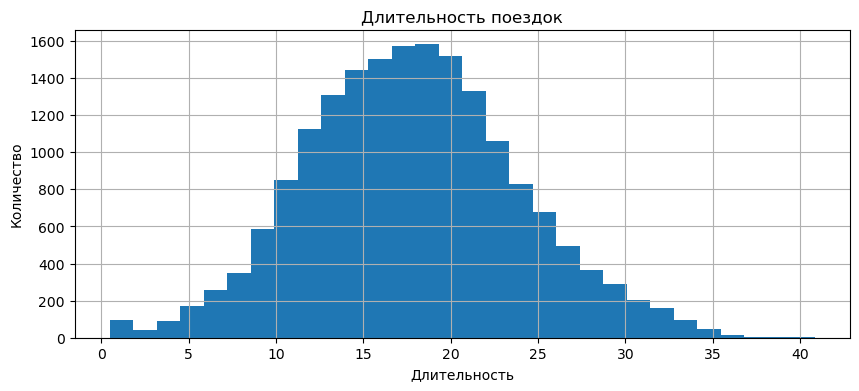

In [29]:
#гистограмма, отображающая распределение данных в столбце 'duration', датафрэйм ride 
ride['duration'].hist(bins=30, grid=True, figsize=(10,4))
plt.title('Длительность поездок')
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.show()

In [30]:
#метод describe, для понимания наиболее актуальной продолжительности поездки
ride['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Данные по продолжительности поездок распределены нормально. Основная масса поездок сконцентрированна в диапазоне от 14 до 22 минут, а среднее значение находится на уровне 18 минут.

**Вывод**
* визуализировали интересующие нас данные, для оценки их распределения
* распределение пользователей имеет свой минимум в городе Москва (вероятно по причине большей конкуренции среди подобных сервисов), а максимум в городе Пятигорск
* пользователи без подписки занимают долю в 54%, соответственно с подпиской - 46%
* основной возраст среднего пользователя равен диапазону от 22 до 28 лет (со средним значением 25 лет)
* протяженность основной массы поездок сконцентрировалась в диапазоне 2.5 - 3.7 км (со средним значением в районе 3.1 км) и небольшим пиком в районе 1 км, что можно объяснить логистической целью
* длительность поездок наиболее часто принимает значения из диапазона 14 - 22 минут (со средним в районе 18)
* полученные распределения выглядят корректно, при имеющихся условиях

#### Шаг 4. Объединение данных

##### Объединение данных о пользователях, их поездках и подписках в один датафрэйм

In [31]:
#применим для этого метод merge() чтобы объеденить user и ride
user_ride1 = user.merge(ride, on='user_id', how='inner')
#а затем добавим subscribe
user_ride = user_ride1.merge(subscribe, on='subscription_type', how='inner')
#выведем несколько первых строк
user_ride.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [32]:
#оценим размерные характеристики только что полученного датафрэйма
user_ride.shape

(18068, 12)

In [33]:
#произведем проверку на пропуски
user_ride.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
date_month           0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Создание дополнительных датафрэймов

In [34]:
#в первом датафрэйм мы соберем данные о пользователях без подписки
#а во втором - с подпиской, используем для этой цели полученный выше датафрэйм
#применив логическую индексацию отберем пользователей без подписки из датафрэйм user_ride
sub_free = user_ride.loc[user_ride['subscription_type'] == 'free']
#выведем первые несколько строк
sub_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [35]:
#тем же самым путем отберем пользователей с подпиской
sub_ultra = user_ride.loc[user_ride['subscription_type'] == 'ultra']
#выведем превые несколько строк
sub_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализация информации о расстоянии и времени поездок для пользователей категорий

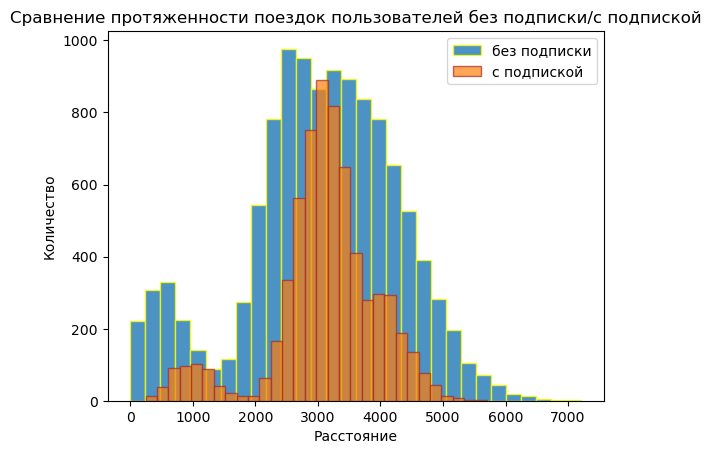

In [36]:
#гистограммы, отображающие сравнение распределений данных в столбце 'distance'
#в зависимости есть подписка ли нет
plt.hist(sub_free['distance'], label='без подписки', alpha=0.8, bins=30, edgecolor='yellow')
plt.hist(sub_ultra['distance'], label='с подпиской', alpha=0.7, bins=30, edgecolor='brown')
plt.title('Сравнение протяженности поездок пользователей без подписки/с подпиской')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [37]:
#размах значений расстояния по пользователям с подпиской
sub_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [38]:
#размах значений расстояния по пользователям без подписки
sub_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Сравнивая две гистограммы можно выделить, что формы распределения практически идентичны. Нормальные распределения со средним значением в районе 3000 метров, снова наблюдаем малый пик в районе 1000 метров. Основное отличие в том, что у пользователей с подпиской основной массив поездок сконцентрирован ближе в среднему значения (меньший размах значений). С 2366 по 3905 у пользователей без подписки, со средним 3114 метров. Против 2785 по 3560, со средним 3148 метров у пользователей с ней. Что указывает на предпочтение пользователями с подпиской более протяженных поездок.

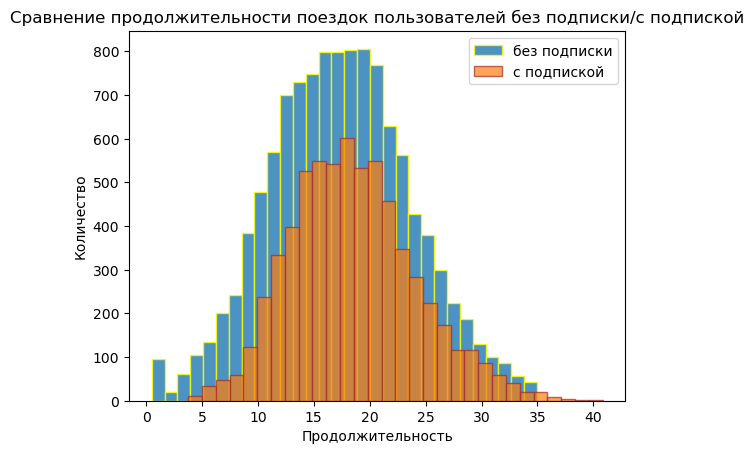

In [39]:
#гистаграммы, отображающие сравнение распределений данных в столбце 'duration'
#в зависимости есть подписка ли нет
plt.hist(sub_free['duration'], label='без подписки', alpha=0.8, bins=30, edgecolor='yellow')
plt.hist(sub_ultra['duration'], label='с подпиской', alpha=0.7, bins=30, edgecolor='brown')
plt.title('Сравнение продолжительности поездок пользователей без подписки/с подпиской')
plt.xlabel('Продолжительность')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [40]:
#размах значений расстояния по пользователям с подпиской
sub_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [41]:
#размах значений расстояния по пользователям без подписки
sub_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Распределение значений по продолжительности у двух категорий представлены нормальным, основное отличие в количестве поездок. Практически на любом уровне продолжительности поездки оно больше у пользователей без подписки (напомним, их 54% от общего количества пользователей). Например на уровне среднего значения (а оно практически совпадает у всех пользователей и условно равно 18 минутам), количество таких поездок у пользователей с подпиской равно 600, а без нее 800. Это лишь указывает на численное преобладание пользователей без подписки.

**Вывод**
* после разделения пользователей на имеющих подписку и не имеющих, проведена ещё одна визуализация
* глядя на объединенные гистограммы по протяженности поездок можно вывести, что оба распределения похожи по форме, распределение пользователей без подписки имеет больший размах, чем пользователей с ней. Можно сделать вывод, что пользователи с подпиской наиболее склонны к запланированным, протяженным поездкам
* в случае с гистограммами продолжительности поездок мы так же видим схожесть по форме. Основное отличие в большем размахе данных по продолжительности и количеству поездок в сторону пользователей без подписки.

#### Шаг 5. Подсчёт выручки

##### Создание датафрэйма с агрегированными данными

In [42]:
#предварительно округлим значения в столбце 'duration' датафрэйма user_ride
user_ride['duration'] = np.ceil(user_ride['duration'])
#проверим разельтат округления
user_ride['duration'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration, dtype: float64

In [43]:
#создадим датафрэйм с агрегированными данными о поездках каждого пользователя на основе user_ride
data_ride = user_ride.groupby(['user_id', 'date_month']).\
agg({'distance': ['sum'], 'user_id': ['count'], 'duration': ['sum'], 'subscription_type': ['min']})
#зададим более удобные названия столбцов
data_ride.columns = ['sum_distance', 'count_ride', 'sum_duration', 'subscription_type']
#выведем несколько первых строк нового датафрэйма
data_ride.head(10)

sum_distance  count_ride  sum_duration subscription_type
user_id date_month                                                          
1       1            7027.511294           2          42.0             ultra
        4             754.159807           1           7.0             ultra
        8            6723.470560           2          46.0             ultra
        10           5809.911100           2          32.0             ultra
        11           7003.499363           3          56.0             ultra
        12           6751.629942           2          28.0             ultra
2       3           10187.723006           3          63.0             ultra
        4            6164.381824           2          40.0             ultra
        6            3255.338202           1          14.0             ultra
        7            6780.722964           2          48.0             ultra

In [44]:
#проверим новый датафрэйм на пропуски
data_ride.isna().sum()

sum_distance         0
count_ride           0
sum_duration         0
subscription_type    0
dtype: int64

##### Добавление в новый датафрэйм столбца

In [45]:
#добавим в датафрэйм data_ride новый столбец с информацией о месячной выручке
#по каждому пользователю
#под данную цель создадим функцию
def money(row):
    if row['subscription_type'] == 'free':
        return 8 * row['sum_duration'] + 50 * row['count_ride']
    elif row['subscription_type'] == 'ultra':
        return 6 * row['sum_duration'] + 199

In [46]:
#применим функцию money к датафрэйму data_ride
#и создадим тем самым новый столбец 'month_bill'
data_ride['month_bill'] = data_ride.apply(money, axis=1)
#выведем несколько первых строк
data_ride.head(10)

sum_distance  count_ride  sum_duration subscription_type  \
user_id date_month                                                             
1       1            7027.511294           2          42.0             ultra   
        4             754.159807           1           7.0             ultra   
        8            6723.470560           2          46.0             ultra   
        10           5809.911100           2          32.0             ultra   
        11           7003.499363           3          56.0             ultra   
        12           6751.629942           2          28.0             ultra   
2       3           10187.723006           3          63.0             ultra   
        4            6164.381824           2          40.0             ultra   
        6            3255.338202           1          14.0             ultra   
        7            6780.722964           2          48.0             ultra   

                    month_bill  
user_id date_month              
1       1                451.0  
        4                241.0  
        8                475.0  
        10               391.0  
        11               535.0  
        12               367.0  
2       3                577.0  
        4                439.0  
        6                283.0  
        7                487.0

**Вывод**
* суммировали характеристики времени, расстояния, а также вывели количество поездок по каждому пользователю, агрегировав данные по датафрэйму user_ride, предварительно округлив значения в столбце с продолжительностью поездок. Все эти данные сохранили в датафрэйм data_ride
* вывели месячный чек каждого пользователя, построив столбец 'month_bill' в новом датафрэйм

#### Шаг 6. Проверка гипотез

##### Гипотеза "Тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без нее"

In [47]:
'''В качестве гипотезы H0 мы установим тот факт, что среднее время поездки пользователей с подпиской
не отличается от времени поездки пользователей без. Тогда гипотезой H1 станет факт того, 
что пользователи с подпиской тратят времени на поездку больше. 
В данном случае мы имеем дело с односторонней, правой гипотезой'''

#создадим переменную, содержащую series с информацией о времени поездок пользователей с подпиской
ultra_duration = sub_ultra['duration']
#и переменную, содержащую среднее по времени поездок пользователей без подписки
free_duration = sub_free['duration']
#уровень статистической значимости
alpha = 0.05
#применим метод st.ttest_ind
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Отвергая гипотезу H0, мы тем самым можем сказать, что длительность поездок пользователей с подпиской в среднем более продолжительна. Из чего следует что подписку оформляют пользователи, заинтересованные в более продолжительных поездках.

##### Гипотеза "Не превышает ли расстояние, которое преодолевают пользователи с подпиской за одну поездку 3130 метров"

In [48]:
'''В качестве гипотезы H0 мы установим тот факт, 
что расстояние поездки пользователей с подпиской условно равно оптимальному в 3130 метров.
Тогда гипотезой H1 станет факт того, 
что расстояние поездок пользователей с подпиской превышает 3130 метров. 
В данном случае мы имеем дело с односторонней правой, гипотезой'''

#создадим переменную, содержащую series с информацией о протяженности поездок пользователей с подпиской
ultra_distance = sub_ultra['distance']
#и переменную, содержащую оптимальную протяженность поездки
opt_distance = 3130
#уровень статистической значимости
alpha = 0.05
#применим метод st.ttest_1samp
results1 = st.ttest_1samp(ultra_distance, opt_distance, alternative='greater')

print('p-значение:', results1.pvalue)

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Исходя из полученных результатов мы не отвергаем гипотезу H0. А это означает, что средняя протяженность поездки пользователей с подпиской не превышает оптимальную в 3130 метров.

##### Гипотеза "Выше ли выручка, которую приносят пользователи с подпиской выручки от пользователей без нее"

In [49]:
'''В качестве гипотезы H0 мы установим тот факт, 
что выручка от пользователей с подпиской условно равна выручке от пользователей без.
А гипотезой H1 установим факт того, 
что выручка от пользователей с подпиской превышает выручку от пользователей без подписки. 
Давайте ответим на вопросы, поставленные односторонней, правой гипотезой'''

#создадим переменную series, содержащую данные о выручке пользователей с подпиской
ultra_bill = data_ride.loc[data_ride['subscription_type'] == 'ultra']['month_bill']
#переменная, с данными о выручке пользователей без подписки
free_bill = data_ride.loc[data_ride['subscription_type'] == 'free']['month_bill']
#зададим уровень статистической значимости
alpha = 0.05
#используем метод st.ttest_ind
results2 = st.ttest_ind(ultra_bill, free_bill, alternative='greater')

print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод, который мы можем сделать исходя из расчетов гласит, что пользователи, имеющие подписку приносят выручку, превышающую по размерам выручку от пользователей без подписки, не смотря на преобладающее количество вторых. В таком случае компании нужно быть заинтересованной, в вопросе продвижения этой опции.

##### Порядок оценки теории, при возможном обновлении изучаемого сервиса

Предполагаемая ситуация: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. В данном случае необходимо было бы воспользоваться гипотезой о равенстве средного генеральной совокупности для зависимых, парных выборок. Выборок до и после некоторых изменений. Осуществить это можно, прибегнув к методу st.ttest_rel(). Гипотеза H0 в данной ситуации устанавливала бы условное равенство двух показателй, тогда как гипотеза H1 говорила бы о том, что количество обращений снизилось. Подобная формулировка является односторонней, левой гипотезой.

#### Общий вывод

##### Общая информация

После импорта необходимых для работы библиотек pandas, matplotlib, numpy и stats, были созданы три датафрэйма (user, ride, subscribe) с данными о пользователях. Затем применив функции head, info и shape поверхностно оценили состояние и типы имеющихся данных. Было определено заменить тип данных в одном из столбцов в датафрэйм ride.

##### Этап предобработки

Проверка данных на пропуски и дубликаты показала только, что датафрэйм user все же имеет некоторое количество дубликатов, которые были затем удалены. Далее тип данных в столбце 'date' датафрэйм ride был успешно заменен на datetime64, методом pd.to_datetime(data['column'], format='%Y.%m.%d'), для предстоящих обработок. На базе вышеупомянутого столбца был создан дополнительный через метод pd.DatetimeIndex(data['column']).month, содержащий только месяц поездки.

##### Исследовательский анализ данных

На данном же этапе мы посредстром гистограмм и разного рода диаграмм применив метод plt визуализировали и описали все особенности полученных характеристик наборов данных:

* частота встречаемости городов
* соотношение пользователей с подпиской и без подписки
* возраст пользователей
* расстояние, которое пользователь преодолел за одну поездку
* продолжительность поездок

На основе инструментов визуализации было установлено следующее:

* наибольшее количество пользователей проживает в городе Пятигорск, в количестве 219. А наименьшее - в городе Москва, в количестве 168
* пользователи без подписки преобладают, но на незначительный объем. 54% против 46%. В количественном отношении это 835 и 699 соответственно
* основной возраст пользователей представлен диапазоном от 22 до 28 лет, со средним значением в 25 лет
* основная протяженность поездок сконцентрирована в диапазоне от 2543 до 3776, со средним значением 3133. Не оставили без внимания небольшой пик в районе 1000 метров, который объяснили потребностью в короткой поездке для транспортных целей
* продолжительность поездок оказалась без сюрпризов. От 14 до 22 - диапазон, который представляет основную продолжительность, со средним значением в 18 минут


##### Объединение данных

На следующем этапе мы объединили все три датафрэйма в один user_ride для удобства анализа. Помог в этом нам метод merge(). После чего стало возможным создать два отдельных датафрэйма: sub_free - пользователи без подписки, sub_ultra - пользователи с подпиской, разделенных по признаку наличия подписки. Разделение произвели, использовав логическую индексацию. На базе новых датафрэймов, содержащих данные о пользователях отдельно с и без подписки, применив метод plt.hist() визуализировали, сравнили и описали имеющиеся различия категорий пользователей:

* сравним показатели по протяженности поездок у пользователей без подписки и с ней. Сами распределения по форме близки, но основное отличие в том, что у пользователей с подпиской основной массив поездок сконцентрирован ближе в среднему значения (меньший размах значений). С 2366 по 3905 у пользователей без подписки, со средним 3114 метров. Против 2785 по 3560, со средним 3148 метров у пользователей с ней. Что указывает на предпочтение пользователями с подпиской более протяженных поездок

* как можно сравнить показатели продолжительности поездок у разных типов пользователей. Распределение значений по продолжительности у двух категорий схожи по форме, они нормальные. Основное отличие в количестве поездок. Практически на любом уровне продолжительности поездки оно больше у пользователей без подписки (напомним, их 54% от общего количества пользователей). Например на уровне среднего значения (а оно практически совпадает у всех пользователей и условно равно 18 минутам), количество таких поездок у пользователей с подпиской равно 600, а без нее 800. Это лишь указывает на численное преобладание пользователей без подписки

##### Подсчет выручки

Для последующих задач будет кстати иметь агрегированные данные. Необходимо выполнив группировку по пользователям и месяцам, оценить суммарную протяженность и продолжительность а так же количество поездок. На данном этапе в этом нам помогли функции groupby и agg. Сформировав новый датафрэйм data_ride, добавим столбец 'month_bill' c месячной выручкой по каждому пользователю. В этом нам поможет функция money, примененная к датафрэйм data_ride.

##### Проверка гипотез

1. Первую гипотезу сформулируем следующим образом. Тратят ли пользователи с подпиской ежемесячно больше времени, чем пользователи без нее. В качестве гипотезы H0 мы установим тот факт, что среднее время поездки пользователей с подпиской не отличается от времени поездки пользователей без. Тогда гипотезой H1 станет факт того, что пользователи с подпиской тратят времени на поездку больше. В данном случае мы имеем дело с односторонней, правой гипотезой. Применив метод st.ttest_ind, с аргументом alternative='greater' получили следующие результаты. Гипотеза H0 отвергнута в сторону альтернативной и мы можем сказать, что длительность поездок пользователей с подпиской в среднем более продолжительна. Из чего следует что подписку оформляют пользователи, заинтересованные в более продолжительных поездках.
2. Вторая гипотеза выглядит так. Было установлено, что с точки зрения износа электросамоката средней, оптимальной протяженностью одной поездки является расстояние в 3130 метров. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает данного порога. В качестве гипотезы H0 мы установим тот факт, что расстояние поездки пользователей с подпиской условно равно оптимальному в 3130 метров. Тогда альтернативной гипотезой H1 станет факт того, что расстояние поездки пользователей с подпиской превышает 3130 метров. В данном случае это одностороняя, правая гипотеза. Применив метод st.ttest_1samp, с аргументом alternative='greater', гипотеза H0 отвергнута не была. Из чего следует, что средняя протяженность поездки пользователей с подпиской не превышает оптимальной в 3130 метров.
3. Третья гипотеза призвана ответить на вопрос, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Определим в качестве гипотезы H0 тот факт, что выручка для пользователей с подпиской условно равна выручке для пользователей без. А гипотезой H1 установим факт того, что выручка для пользователей с подпиской превышает выручку для пользователей без подписки. Ответить на имеющийся вопрос снова поможет метод st.ttest_ind, с аргументом alternative='greater'. После выполненных расчетов можем сказать, что пользователи, имеющие подписку приносят выручку, превышающую размерами выручку от пользователей без подписки.
4. Было предложено определить тип теста, для проверки предложеной гипотезы. Суть гипотезы заключается в предпологаемой ситуации, при которой техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. В данном случае необходимо было бы воспользоваться гипотезой о равенстве средного генеральной совокупности для зависимых, парных выборок. Выборок до и после некоторых изменений. Осуществить это можно, прибегнув к методу st.ttest_rel(). Подобная формулировка является односторонней, левой гипотезой.

##### Итог всего исследования

Из всего рассмотренного выше можно вывести, что пользователи с подпиской имеют поездки более продолжительные, при этом не превышая по расстоянию установленный порог повышенного износа (3133 метров). К тому же при всех этих условиях выручка от пользователей с подпиской превышает выручку от пользователей без нее. Следовательно имеет смысл дополнительно стимулировать пользователя на покупку подписки. 